In [1]:
# LIBS
import yfinance as yf

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd, numpy as np
import time
from time import sleep
import datetime
from datetime import datetime, timedelta, timezone
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'g'
# df = pd.read_excel("Retail2.xlsx")

# For Graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
# import plotly.plotly as py
import plotly.graph_objs as go
import plotly

### Input Data

In [2]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "RUB=X", #^GSPC RTSI.ME

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "60d", #3285d

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "15m", #60m

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2020-06-24 00:00:00+01:00,68.752197,68.758400,68.737900,68.755096,0
2020-06-24 00:15:00+01:00,68.749298,68.756599,68.737900,68.747101,0
2020-06-24 00:30:00+01:00,68.759399,68.759399,68.740402,68.749603,0
2020-06-24 00:45:00+01:00,68.749001,68.754501,68.748703,68.748703,0
2020-06-24 01:00:00+01:00,68.737000,68.768402,68.737000,68.751701,0
...,...,...,...,...,...
2020-09-15 09:30:00+01:00,75.175697,75.225998,75.117500,75.209007,0
2020-09-15 09:45:00+01:00,75.191597,75.259209,75.157402,75.202003,0
2020-09-15 10:00:00+01:00,75.192703,75.226112,75.082397,75.116096,0


In [3]:
type(data), data.index[0], data.shape

(pandas.core.frame.DataFrame,
 Timestamp('2020-06-24 00:00:00+0100', tz='Europe/London'),
 (5624, 5))

In [5]:
data2 = data.assign(dHL = data['High'] - data['Low'] , T = data.index.time)
data2.head(), data2.shape

(                                Open       High        Low      Close  Volume  \
 Datetime                                                                        
 2020-06-24 00:00:00+01:00  68.752197  68.758400  68.737900  68.755096       0   
 2020-06-24 00:15:00+01:00  68.749298  68.756599  68.737900  68.747101       0   
 2020-06-24 00:30:00+01:00  68.759399  68.759399  68.740402  68.749603       0   
 2020-06-24 00:45:00+01:00  68.749001  68.754501  68.748703  68.748703       0   
 2020-06-24 01:00:00+01:00  68.737000  68.768402  68.737000  68.751701       0   
 
                                 dHL         T  
 Datetime                                       
 2020-06-24 00:00:00+01:00  0.020500  00:00:00  
 2020-06-24 00:15:00+01:00  0.018700  00:15:00  
 2020-06-24 00:30:00+01:00  0.018997  00:30:00  
 2020-06-24 00:45:00+01:00  0.005798  00:45:00  
 2020-06-24 01:00:00+01:00  0.031403  01:00:00  ,
 (5624, 7))

In [6]:
data2['T'].unique()
GT = data2.groupby('T').mean()
GT[GT['dHL']>=0.2]

,Open,High,Low,Close,Volume,dHL
T,,,,,,
01:00:00,72.771746,72.830089,72.613100,72.716964,0,0.216989
02:00:00,72.703675,72.798627,72.598363,72.682625,0,0.200263
06:00:00,72.711662,72.794883,72.578179,72.689667,0,0.216705
08:00:00,72.737739,72.880851,72.603967,72.743394,0,0.276885
21:45:00,72.819132,72.920536,72.663761,72.782903,0,0.256775
22:00:00,72.830703,72.904683,72.642695,72.769984,0,0.261988
23:00:00,72.818878,72.897808,72.662285,72.788532,0,0.235523
23:15:00,72.811018,72.881468,72.675545,72.763781,0,0.205923


### Graph volatility

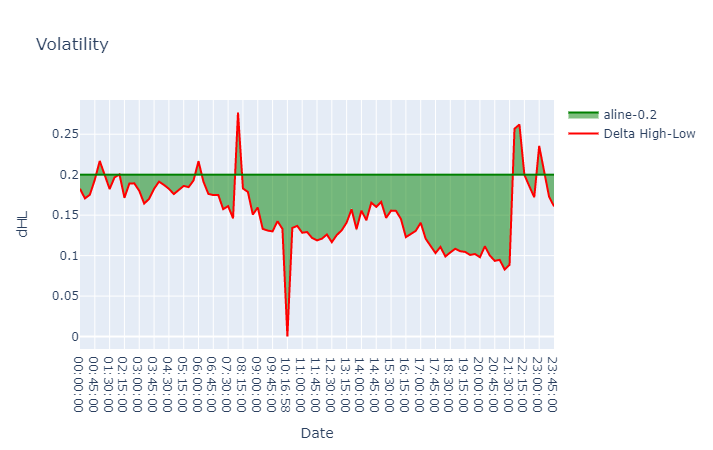

In [7]:
# Graph_volatility for formalize strtgy
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

lm_f = lambda s: [0.2 for _ in range(GT.shape[0])]

init_notebook_mode(connected=True)
# создаем traces для визуализации
trace0 = go.Scatter(
    x=list(GT.index),
    y=list(GT['dHL'].values),
#     mode = 'markers+lines',
    name = 'Delta High-Low',
    line=dict(
                color="Red",
                width=2,
#                 dash="dashdot",
            ),
#     fill = 'toself',
    
)

trace1 = go.Scatter(
    x=list(GT.index),
    y=list(lm_f(777)),
#     mode = 'markers+lines',
    name = 'aline-0.2',
    line=dict(
                color="Green",
                width=2,
#                 dash="dashdot",
            ),
#     fill = 'toself',
    fill='tonexty',
)

# trace2 = go.Scatter(
#     x=list(pd.DataFrame(pred.predicted_mean).index),
#     y=list(pd.DataFrame(pred.predicted_mean)[0]),
# #     mode = 'markers+lines',
#     name = 'F_High',
#     line=dict(
#                 color="#a76bcf",
#                 width=2,
# #                 dash="dashdot",
#             ),
# #     fillcolor="LightSalmon",
# #     fill = 'toself',
# #     fill='tozeroy',
#     fill='tonexty',
# )

data = [trace0, trace1]
layout = {'title': 'Volatility', 'xaxis': {'title': 'Date'}, 'yaxis': {'title': 'dHL'}}

# создаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
# iplot(fig, show_link=False)
iplot(fig)